#Wordle Turtle - A Wordle Bot and Playable Game
## Ava Schneider and Ellery Bock
### Team Shared Brain Cell

In [ ]:
# from google.colab import drive
import os
import pandas as pd
from collections import Counter
import random
import matplotlib.pyplot as plt

In [ ]:
# drive.mount('/content/drive')
# folder_path = '/content/drive/MyDrive/WordleTurtle'
# os.chdir(folder_path)

with open('wordle-nyt-answers-alphabetical.txt', 'r') as f:
    answer_list= f.read().splitlines()
with open('wordle-nyt-allowed-guesses-update-12546.txt', 'r') as f:
    guess_list = f.read().splitlines()

print("Words from file1:", answer_list)
print("Words from file2:", guess_list)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Words from file1: ['aback', 'abase', 'abate', 'abbey', 'abbot', 'abhor', 'abide', 'abled', 'abode', 'abort', 'about', 'above', 'abuse', 'abyss', 'acorn', 'acrid', 'actor', 'acute', 'adage', 'adapt', 'adept', 'admin', 'admit', 'adobe', 'adopt', 'adore', 'adorn', 'adult', 'affix', 'afire', 'afoot', 'afoul', 'after', 'again', 'agape', 'agate', 'agent', 'agile', 'aging', 'aglow', 'agony', 'agree', 'ahead', 'aider', 'aisle', 'alarm', 'album', 'alert', 'algae', 'alibi', 'alien', 'align', 'alike', 'alive', 'allay', 'alley', 'allot', 'allow', 'alloy', 'aloft', 'alone', 'along', 'aloof', 'aloud', 'alpha', 'altar', 'alter', 'amass', 'amaze', 'amber', 'amble', 'amend', 'amiss', 'amity', 'among', 'ample', 'amply', 'amuse', 'angel', 'anger', 'angle', 'angry', 'angst', 'anime', 'ankle', 'annex', 'annoy', 'annul', 'anode', 'antic', 'anvil', 'aorta', 'apart', 'aphid', 'aping

## Pre-Processing
Here we create three dataframes, one for the list of answer words, one for the list of guess words, and one of the two combined. Each dataframe has the whole word in the first column, and each letter alone in the subsequent five columns. Truncated versions of these dataframes are printed below

In [ ]:
def words_to_df(words_list):
  data = []
  for word in words_list:
    row = [word] + list(word)  # first col is word, next cols are letters
    data.append(row)

  columns = ["word"] + [f"letter_{i+1}" for i in range(5)]

  words_df = pd.DataFrame(data, columns=columns)

  return words_df

In [ ]:
all_words = answer_list + guess_list
all_words_df = words_to_df(all_words)
print(all_words_df)

answer_list_df = words_to_df(answer_list)
print(answer_list_df)

guess_list_df = words_to_df(guess_list)
print(guess_list_df)

        word letter_1 letter_2 letter_3 letter_4 letter_5
0      aback        a        b        a        c        k
1      abase        a        b        a        s        e
2      abate        a        b        a        t        e
3      abbey        a        b        b        e        y
4      abbot        a        b        b        o        t
...      ...      ...      ...      ...      ...      ...
14850  zuzim        z        u        z        i        m
14851  zygal        z        y        g        a        l
14852  zygon        z        y        g        o        n
14853  zymes        z        y        m        e        s
14854  zymic        z        y        m        i        c

[14855 rows x 6 columns]
       word letter_1 letter_2 letter_3 letter_4 letter_5
0     aback        a        b        a        c        k
1     abase        a        b        a        s        e
2     abate        a        b        a        t        e
3     abbey        a        b        b        e   

## Heuristic Part One
This function is a key part of our heuristic function. The output of this cell displays the frequency at which each letter appears in each position in the list of answer words.

In [ ]:
def letter_frequency(words_df):
    letter_frequencies = {}

    for i in range(1, 6):
      letter_frequencies[i] = {}
      for letter in "abcdefghijklmnopqrstuvwxyz":
        letter_frequencies[i][letter] = 0

    for i in range(1, 6):
      column_name = f"letter_{i}"
      for letter in words_df[column_name]:
        if letter.lower() in "abcdefghijklmnopqrstuvwxyz":
            letter_frequencies[i][letter.lower()] += 1

    frequency_df = pd.DataFrame(letter_frequencies)
    return frequency_df

In [ ]:
frequency_df = letter_frequency(answer_list_df)
print(frequency_df)

     1    2    3    4    5
a  140  304  306  162   63
b  173   16   56   24   11
c  198   40   56  150   31
d  111   20   75   69  118
e   72  241  177  318  422
f  135    8   25   35   26
g  115   11   67   76   41
h   69  144    9   28  137
i   34  201  266  158   11
j   20    2    3    2    0
k   20   10   12   55  113
l   87  200  112  162  155
m  107   38   61   68   42
n   37   87  137  182  130
o   41  279  243  132   58
p  141   61   57   50   56
q   23    5    1    0    0
r  105  267  163  150  212
s  365   16   80  171   36
t  149   77  111  139  253
u   33  185  165   82    1
v   43   15   49   45    0
w   82   44   26   25   17
x    0   14   12    3    8
y    6   22   29    3  364
z    3    2   11   20    4


## Heuristic Part Two
This next function scores each word in the given list based on the frequency of each letter in each location. These values are summed and appended as the score for the given word. The higher the score, the better a guess it is.

In [ ]:
def calculate_word_score(word_row):
    score = 0
    for i in range(1, 6):  # 1st index is whole word. Need letters only
        letter = word_row[i]
        score += frequency_df.at[letter, i]
    return score

## Best Starting Word
By giving the list of possible answers to this funciton, we find that 'SLATE' is the best starting guess. Out of all answer words, it has the highest number of common letters at each location. The "at each location" is key, as getting a green square (2) as feedback from the game will eliminate the maximum amount of possible guesses. 'SLATE' has a score of 1432.

In [ ]:
answer_list_df["score"] = answer_list_df.apply(calculate_word_score, axis=1)
print(answer_list_df)
print()

guess_list_df["score"] = guess_list_df.apply(calculate_word_score, axis=1)
print(guess_list_df)

<ipython-input-7-8caf2418853d>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  letter = word_row[i]


       word letter_1 letter_2 letter_3 letter_4 letter_5  score
0     aback        a        b        a        c        k    725
1     abase        a        b        a        s        e   1055
2     abate        a        b        a        t        e   1023
3     abbey        a        b        b        e        y    894
4     abbot        a        b        b        o        t    597
...     ...      ...      ...      ...      ...      ...    ...
2304  young        y        o        u        n        g    673
2305  youth        y        o        u        t        h    726
2306  zebra        z        e        b        r        a    513
2307  zesty        z        e        s        t        y    827
2308  zonal        z        o        n        a        l    736

[2309 rows x 7 columns]


In [ ]:
max_score_index = answer_list_df["score"].idxmax()
max_score_row = answer_list_df.loc[max_score_index]

print(max_score_row)

word        slate
letter_1        s
letter_2        l
letter_3        a
letter_4        t
letter_5        e
score        1432
Name: 1773, dtype: object


In [ ]:
answer_columns = answer_list_df[["word", "score"]]
guess_colomns = guess_list_df[["word", "score"]]

answer_score_list = answer_columns.values.tolist()
guess_score_list = guess_colomns.values.tolist()

print(answer_score_list)
print(guess_score_list)

[['aback', 725], ['abase', 1055], ['abate', 1023], ['abbey', 894], ['abbot', 597], ['abhor', 509], ['abide', 913], ['abled', 704], ['abode', 890], ['abort', 802], ['about', 734], ['above', 866], ['abuse', 914], ['abyss', 392], ['acorn', 703], ['acrid', 619], ['actor', 635], ['acute', 906], ['adage', 964], ['adapt', 769], ['adept', 640], ['admin', 509], ['admit', 632], ['adobe', 849], ['adopt', 706], ['adore', 975], ['adorn', 683], ['adult', 740], ['affix', 339], ['afire', 986], ['afoot', 776], ['afoul', 628], ['after', 789], ['again', 745], ['agape', 929], ['agate', 1018], ['agent', 763], ['agile', 1001], ['aging', 640], ['aglow', 412], ['agony', 940], ['agree', 1054], ['ahead', 741], ['aider', 946], ['aisle', 1005], ['alarm', 838], ['album', 520], ['alert', 920], ['algae', 991], ['alibi', 641], ['alien', 1054], ['align', 812], ['alike', 1083], ['alive', 1073], ['allay', 978], ['alley', 1134], ['allot', 837], ['allow', 601], ['alloy', 948], ['aloft', 871], ['alone', 1187], ['along', 80

## The Game
This class is our implementation of Wordle. It behaves exactly as the original game does. Upon instantiation, it selects a random word from the answer list, and the player or bot can make guesses with calls to the make_guess() function. It then gives feedback, although instead of colored squares, a 0 means the letter is not in the answer, a 1 means the letter is in the answer but in the wrong position, and a 2 means the letter is in the right position in the answer. This can be used by human and bot alike to facilitate their next guess. The game ends when the correct answer is guessed, or the number of guesses reaches 6.

In [ ]:
class Wordle:
    def __init__(self, answer_list, guess_list, verbose):
        self.answer_list = answer_list
        self.guess_list = guess_list
        self.answer = random.choice(self.answer_list)
        self.allowed_guesses = 6
        self.guess_history = []
        self.game_state = 1  # 1 -> in progress, 0 -> loss, 2 -> win
        self.guess = ""
        self.num_guesses = 0
        self.verbose = verbose
        if self.verbose:
          print("Welcome to Wordle! To make a guess, call wordle.make_guess("").")
          print("After your guess, your feedback will appear.")
          print("A 0 means your guessed letter is not in the answer.")
          print("A 1 means your guessed letter is in the answer, but not in the position you guessed.")
          print("A 2 means your guessed letter in the answer in the position you guessed.")
          print("Good Luck!")
          print()

    def get_game_state(self):
      return self.game_state

    def get_guess_history(self):
      return self.guess_history

    def get_answer(self):
      return self.answer

    def get_num_guesses(self):
      return self.num_guesses

    def make_guess(self, guess):
      if self.get_game_state() != 1:  # game is over, redundant check
        print("Game is over, to play again run: wordle = Wordle(answer_list, guess_list, verbose = True)")
        return

      self.num_guesses += 1
      self.guess = guess.lower()  # for user input

      if guess not in self.answer_list and guess not in self.guess_list:  # if invalid word
        print("Not a valid word.")
        self.num_guesses -= 1  # invalid guess doesn't count
        return

      self.guess_history.append(guess)

      feedback_array = [[letter, 0] for letter in guess]  # initialize with 0 feedback for all letters

      for i in range(len(self.answer)):  # mark correct letters (2)
          if self.answer[i] == guess[i]:
              feedback_array[i][1] = 2

      for i in range(len(self.answer)):  # mark letters in the wrong place (1)
          if feedback_array[i][1] == 0:
              if guess[i] in self.answer:
                feedback_array[i][1] = 1

      if self.verbose:
        print("Guess:", guess)
        print("Feedback:", feedback_array)

      if self.guess == self.answer:  # correct guess, game over
        self.game_state = 2
        if self.verbose:
          print(f"Congratulations! You guessed the word! '{self.answer}'.")
        return feedback_array

      if self.num_guesses >= self.allowed_guesses:  # out of guesses, game over
        self.game_state = 0
        if self.verbose:
          print(f"1 IQ fr, the answer was '{self.answer}'.")
        return feedback_array

      return feedback_array


## Sample Manual Game

In [ ]:
wordle = Wordle(answer_list, guess_list, verbose = True)
wordle.make_guess("slate")
wordle.make_guess("arise")
wordle.make_guess("smack")
wordle.make_guess("ababa")
wordle.make_guess("onion")
wordle.make_guess("gross")
wordle.make_guess("black")
wordle.make_guess("swift")

Welcome to Wordle! To make a guess, call wordle.make_guess().
After your guess, your feedback will appear.
A 0 means your guessed letter is not in the answer.
A 1 means your guessed letter is in the answer, but not in the position you guessed.
A 2 means your guessed letter in the answer in the position you guessed.
Good Luck!

Guess: slate
Feedback: [['s', 1], ['l', 2], ['a', 2], ['t', 0], ['e', 0]]
Guess: arise
Feedback: [['a', 1], ['r', 0], ['i', 0], ['s', 2], ['e', 0]]
Guess: smack
Feedback: [['s', 1], ['m', 0], ['a', 2], ['c', 0], ['k', 2]]
Not a valid word.
Guess: onion
Feedback: [['o', 0], ['n', 0], ['i', 0], ['o', 0], ['n', 0]]
Guess: gross
Feedback: [['g', 0], ['r', 0], ['o', 0], ['s', 2], ['s', 1]]
Guess: black
Feedback: [['b', 0], ['l', 2], ['a', 2], ['c', 0], ['k', 2]]
1 IQ fr, the answer was 'flask'.
Game is over, to play again run: wordle = Wordle(answer_list, guess_list, verbose = True)


## Random Baseline
This is our random baseline that is very, very bad at playing Wordle. It guesses random words, from both lists until the final guess, like our other bots, until it wins or loses. This is able to beat Wordle a little less than .1% of the time.

In [ ]:
num_wins_rand = 0
num_losses_rand = 0
guesses_to_win_rand = []
for i in range(10000):
  random_wordle = Wordle(answer_list, guess_list, verbose = False)
  while random_wordle.game_state == 1:
    if random_wordle.num_guesses < 5:
      random_wordle.make_guess(random.choice(all_words_df["word"]))
    elif random_wordle.num_guesses == 5:
      random_wordle.make_guess(random.choice(answer_list_df["word"]))

  if random_wordle.get_game_state() == 2:
    guesses_to_win_rand.append(random_wordle.num_guesses)
    num_wins_rand += 1
  if random_wordle.get_game_state() == 0:
    num_losses_rand += 1

print("Total Games: 10000")
print("Number of Wins: ", num_wins_rand)
print("Number of Losses: ", num_losses_rand)

Total Games: 10000
Number of Wins:  9
Number of Losses:  9991


## Constraint Propegation

This function performs constraint propagation, narrowing down the domains (possible letters) of the variables (each letter position) using the feedback as constraints. The function returns only words that satisfy every constraint. There will always be at least one, the answer. By pruning the search space, the solver incrementally converges toward finding the answer.

In [ ]:
def eliminate_words(answer_list, guess_list, guess, feedback_array):
    new_answer_list = []
    new_guess_list = []

    for word, score in answer_list:
        valid = True
        for i in range(5):
            letter, feedback = feedback_array[i] #getting the letter and feedback
            if feedback == 0 and letter in word: #if is in word when it SHOULDN'T be
                valid = False # not a valid guess
                break

            if feedback == 1 and (letter not in word or letter == word[i]): # if letter is in not in word or is in guessed position when it SHOULDN'T be
                valid = False
                break

            if feedback == 2 and letter != word[i]: # if letter is not in word at the correct position when it SHOULD be in that position
                valid = False
                break

        if valid:
            new_answer_list.append([word, score])

    for word, score in guess_list: # ditto see above
        valid = True
        for i in range(5):
            letter, feedback = feedback_array[i]
            if feedback == 0 and letter in word:
                valid = False
                break

            if feedback == 1 and (letter not in word or letter == word[i]):
                valid = False
                break

            if feedback == 2 and letter != word[i]:
                valid = False
                break

        if valid:
            new_guess_list.append([word, score])

    return new_answer_list, new_guess_list

## Constraint Propegation Solver
This solver uses the elimination function to make better guesses than the random solver.
It models roughly how a human would play the game. As a human player, you look at the feedback you get, and go through the list of words that you know that satisfy these constraints.

Like the random solver, it makes guesses from both lists to maximuze the amount of learned information (constraints) until the final guess where it makes a last hail-mary guess at the answer. By making a random choice out of the reduced problem domain (list of valid words), we get a model that beats Wordle 93.9% of the time.

In [ ]:
num_wins_elim = 0
num_losses_elim = 0
feedback = {}
guesses_to_win_elim = []
missed_answers_elim = []

for i in range(10000):
    eliminate_wordle = Wordle(answer_list, guess_list, verbose=False)

    current_answer_list = answer_score_list.copy()  # so it doesn't eliminate from the real lists
    current_guess_list = guess_score_list.copy()

    while eliminate_wordle.get_game_state() == 1:
      if eliminate_wordle.num_guesses < 5:  # random guess from both eliminated lists
        current_guess = random.choice(current_guess_list + current_answer_list)
        feedback = eliminate_wordle.make_guess(current_guess[0])
        current_answer_list, current_guess_list = eliminate_words(current_answer_list, current_guess_list, current_guess, feedback)

      elif eliminate_wordle.num_guesses == 5:  # random guess from answer list only on last guess (before guess made num_guesses is 5)
        current_guess = random.choice(current_answer_list)
        feedback = eliminate_wordle.make_guess(current_guess[0])

    if eliminate_wordle.get_game_state() == 2:
      guesses_to_win_elim.append(eliminate_wordle.num_guesses)
      num_wins_elim += 1
    if eliminate_wordle.get_game_state() == 0:
      num_losses_elim += 1
      missed_answers_elim.append(eliminate_wordle.get_answer())

print("Total Games: 10000")
print("Number of Wins: ", num_wins_elim)
print("Number of Losses: ", num_losses_elim)

missed_counts = Counter(missed_answers_elim)
sorted_missed = sorted(missed_counts.items(), key=lambda x: x[1], reverse=True)
filtered_missed = [(word, count) for word, count in sorted_missed if count > 1]  # only print ones it misses more than once for brevity

print("Answers Turtle Missed More Than Once:")
for i, (word, count) in enumerate(filtered_missed, start=1):
    print(f"{word}: {count}", end="\t")
    if i % 10 == 0:
        print()

Total Games: 10000
Number of Wins:  9387
Number of Losses:  613
Answers Turtle Missed More Than Once:
giver: 6	haste: 5	stoop: 4	paper: 4	breed: 4	plate: 4	might: 3	honey: 3	wooer: 3	rider: 3	
gamer: 3	watch: 3	jolly: 3	biddy: 3	boxer: 3	bezel: 3	spunk: 3	grape: 3	poker: 3	bunch: 3	
hatch: 3	girth: 3	ditch: 3	cinch: 3	grave: 3	betel: 3	taunt: 3	froze: 3	zonal: 2	shale: 2	
dolly: 2	scare: 2	moose: 2	blood: 2	eager: 2	lapel: 2	wacky: 2	stint: 2	mafia: 2	swell: 2	
lever: 2	vaunt: 2	petty: 2	piece: 2	trite: 2	witch: 2	hinge: 2	diner: 2	harry: 2	lower: 2	
tract: 2	crook: 2	spare: 2	rarer: 2	fiber: 2	crate: 2	magma: 2	freer: 2	swash: 2	icing: 2	
riper: 2	gauze: 2	lowly: 2	wreak: 2	water: 2	winch: 2	stage: 2	elder: 2	terse: 2	batty: 2	
borax: 2	mower: 2	snore: 2	chaff: 2	goose: 2	pride: 2	badly: 2	refer: 2	table: 2	glare: 2	
local: 2	maker: 2	witty: 2	smell: 2	clove: 2	state: 2	caste: 2	tabby: 2	rower: 2	corer: 2	
rover: 2	paler: 2	finer: 2	later: 2	timer: 2	chill: 2	munch: 2	golly: 2	baggy: 

## Heuristic Part Three
This function uses the heuristic described above. Given the pruned lists of words, instead of making a random choice, we make a heuristic-informed choice. We choose the word that will give us the maxiumum amount of information, the one with the most common letters at each location, which in turn will prune our problem domain more efficiently.

The conditionals:

It is possible that we have eliminated every word in the guess list, but the answer list will always at least contain the answer.

If the number of words in the answer list is less than the amount of remaining guesses, this is a guarenteed win and an answer word should be chosen.

Otherwise, the max from both lists are taken.

After this, we use a multiplier to weigh the answer words more heavily. This guides the solver towards guessing answer words at different key parts of the game. We want to guess an answer word to start, to get as much information about the answer list as possible, so a multiplier of 2 will guarentee this. Afterwards, we want to use both lists because we can get more general information about the constraints this way. In the 4th and 5th guesses, we nudge a little further toward the answer list, and on the final guess, the same as the other two solvers, we make the final hail-mary guess only from the answer list.


In [ ]:
def use_heuristic(answer_score_list, guess_score_list, multiplier, num_guesses):

    if len(guess_score_list) == 0:  # no more valid guessing words (were all eliminated)
      top_answer_list = max(answer_score_list, key=lambda x: x[1])
      return top_answer_list[0]

    elif len(answer_score_list) <= (6 - num_guesses):  # if there are less words in answer list than number of guesses left, guarenteed win
      top_answer_list = max(answer_score_list, key=lambda x: x[1])  # take max scored word
      return top_answer_list[0]
    else :  # enough words in both lists
      top_guess_list = max(guess_score_list, key=lambda x: x[1])
      top_answer_list = max(answer_score_list, key=lambda x: x[1])

      top_answer_list[1] = top_answer_list[1] * multiplier  # weight the answer words more heavily

      if top_answer_list[1] > top_guess_list[1]:
          return top_answer_list[0]
      else:
        return top_guess_list[0]

## The Heuristic Solver (The Wordle Turtle)
This solver uses the heuristic to make an informed guess, and the problem domain is pruned with the feedback from this informed guess. Using all of the tricks in our bag, the Wordle Turtle was able to beat Wordle 98.3% of the time.


In [ ]:
num_wins_heur = 0
num_losses_heur = 0
feedback = {}
guesses_to_win_heur = []
missed_answers_heur = []

for i in range(10000):
    heuristic_wordle = Wordle(answer_list, guess_list, verbose=False)

    current_answer_list = answer_score_list.copy()
    current_guess_list = guess_score_list.copy()
    multipliers = [2, 1, 1, 1.1, 1.2, 2]  # weight the answer words more heavily at key points in the game

    while heuristic_wordle.get_game_state() == 1:
        current_guess = use_heuristic(current_answer_list, current_guess_list, multipliers[heuristic_wordle.num_guesses], heuristic_wordle.num_guesses)  # not random, pick max score
        feedback = heuristic_wordle.make_guess(current_guess)
        current_answer_list, current_guess_list = eliminate_words(current_answer_list, current_guess_list, current_guess, feedback)

    if heuristic_wordle.get_game_state() == 2:
      guesses_to_win_heur.append(heuristic_wordle.num_guesses)
      num_wins_heur += 1
    if heuristic_wordle.get_game_state() == 0:
      num_losses_heur += 1
      missed_answers_heur.append(heuristic_wordle.get_answer())

print("Total Games: 10000")
print("Number of Wins: ", num_wins_heur)
print("Number of Losses: ", num_losses_heur)

missed_counts = Counter(missed_answers_heur)
sorted_missed = sorted(missed_counts.items(), key=lambda x: x[1], reverse=True)

print("Answers Turtle Missed:")
for i, (word, count) in enumerate(sorted_missed, start=1):
    print(f"{word}: {count}", end="\t")
    if i % 10 == 0:
        print()


Total Games: 10000
Number of Wins:  9818
Number of Losses:  182
Answers Turtle Missed:
shape: 11	wight: 8	homer: 8	haste: 8	joker: 7	krill: 7	river: 7	jazzy: 7	jolly: 7	hound: 7	
viper: 6	handy: 6	diver: 6	refer: 5	rower: 5	staff: 5	hedge: 5	score: 5	hover: 5	woken: 5	
harry: 5	rover: 5	jaunt: 4	shake: 4	erode: 4	giver: 4	wound: 4	watch: 3	drown: 3	graze: 3	
daddy: 3	hatch: 2	wider: 2	gleam: 2	smell: 1	hilly: 1	happy: 1	snake: 1	

## Results
Results will be discussed in accompianing paper.

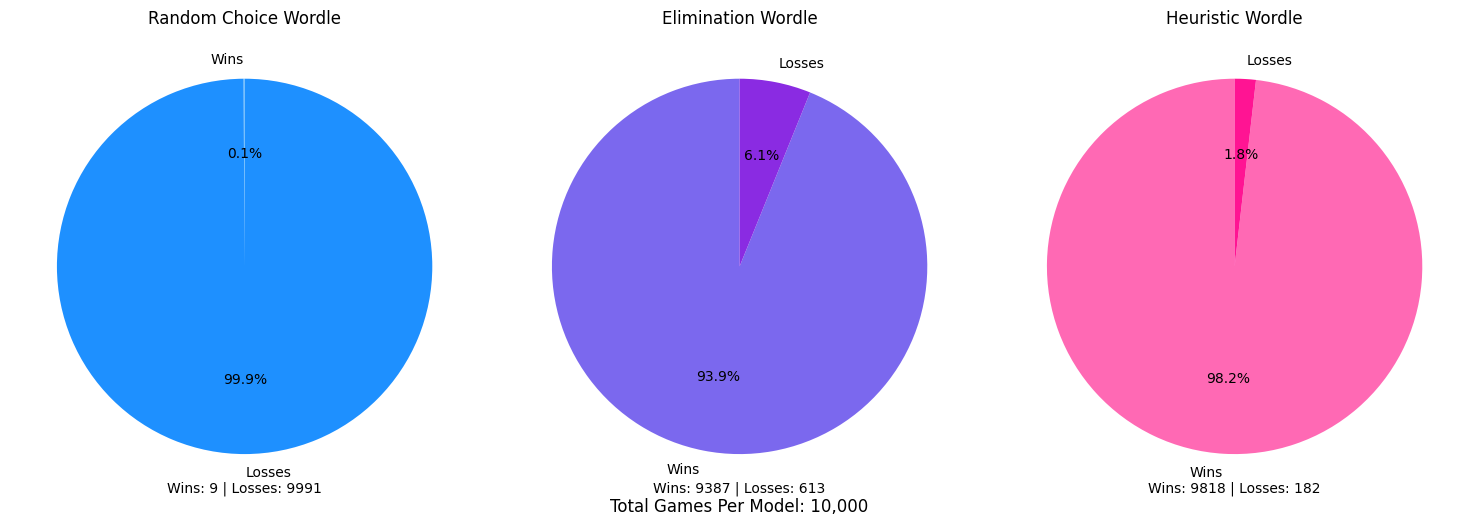

In [ ]:
titles = ["Random Choice Wordle", "Elimination Wordle", "Heuristic Wordle"]
num_wins = [num_wins_rand, num_wins_elim, num_wins_heur]
num_losses = [num_losses_rand, num_losses_elim, num_losses_heur]

colors = [["lightskyblue", "dodgerblue"],
          ["mediumslateblue", "blueviolet"],
          ["hotpink", "deeppink"]]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, title in enumerate(titles):
    labels = ["Wins", "Losses"]
    sizes = [num_wins[i], num_losses[i]]

    axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors[i])
    axes[i].set_title(title)
    axes[i].text(0, -1.2, f"Wins: {num_wins[i]} | Losses: {num_losses[i]}",
                 ha="center", fontsize=10, color="black")

footer_text = "Total Games Per Model: 10,000"
fig.text(0.5, 0.01, footer_text, ha="center", fontsize=12, color="black")

plt.tight_layout()
plt.show()


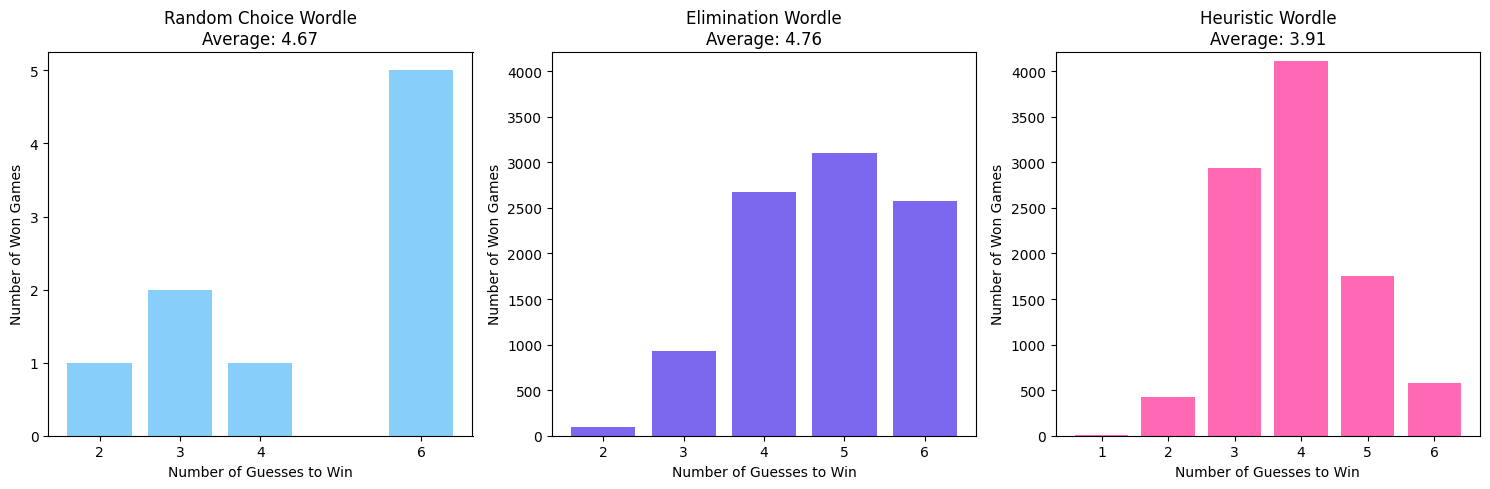

In [ ]:
all_data = [guesses_to_win_rand, guesses_to_win_elim, guesses_to_win_heur]
titles = ["Random Choice Wordle", "Elimination Wordle", "Heuristic Wordle"]
colors = ["lightskyblue", "mediumslateblue", "hotpink"]

plt.figure(figsize=(15, 5))

max_y = 0
for guesses in all_data[1:]: # keep y-scale the same for elimination and heuristic
    frequencies = Counter(guesses)
    max_y = max(max_y, max(frequencies.values())) + 100

for i, (guesses, title, color) in enumerate(zip(all_data, titles, colors), start=1):
    frequencies = Counter(guesses)
    values = list(frequencies.keys())
    counts = list(frequencies.values())
    avg_guesses = sum(guesses) / len(guesses)

    plt.subplot(1, 3, i)
    plt.bar(values, counts, tick_label=values, color=color)
    plt.title(title + f"\nAverage: {avg_guesses:.2f}")
    plt.xlabel("Number of Guesses to Win")
    plt.ylabel("Number of Won Games")

    if i in [2, 3]:
        plt.ylim(0, max_y)

plt.tight_layout()
plt.show()

